## Research Task - Incorporate feedback to Transit Performance Metrics Portfolio #1514

via Juan Matute
>If you're taking requests, I'd like to see the Table 8.1 performance metrics on a statewide basis, along with a 
>- list for each performance metric of which individual transit agency-mode of service combinations are 
>- in the bottom 5% (approximately two standard deviations from the mean) for each. 
>
>This would be illustrative for discussion purposes.


## Table 8.1
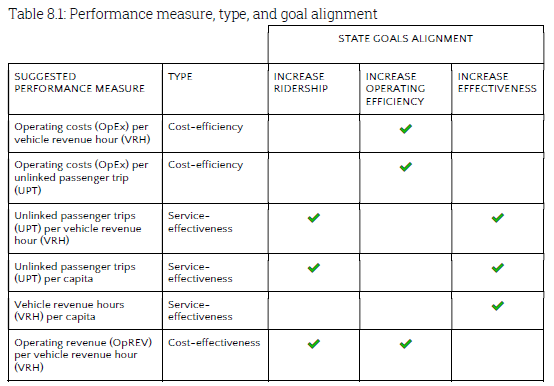

In [19]:
import altair as alt
import numpy as np
import pandas as pd
from new_transit_metrics_utils import GCS_FILE_PATH, make_long, sum_by_group

In [2]:
df = pd.read_parquet(f"{GCS_FILE_PATH}raw_transit_performance_metrics_data.parquet")

In [3]:
df.columns

Index(['agency_name', 'agency_status', 'city', 'mode', 'service', 'ntd_id',
       'reporter_type', 'reporting_module', 'state', 'primary_uza_name',
       'year', 'upt', 'vrh', 'vrm', 'opexp_total', 'RTPA', '_merge'],
      dtype='object')

In [4]:
df_agg = (
    df.groupby(["ntd_id", "city", "agency_name", "mode"])
    .agg({"upt": "sum", "vrh": "sum", "vrm": "sum", "opexp_total": "sum"})
    .reset_index()
)

In [5]:
calc_dict = {
    "opex_per_vrh": ("opexp_total", "vrh"),
    "opex_per_vrm": ("opexp_total", "vrm"),
    "upt_per_vrh": ("upt", "vrh"),
    "upt_per_vrm": ("upt", "vrm"),
    "opex_per_upt": ("opexp_total", "upt"),
}

for new_col, (num, dem) in calc_dict.items():
    df_agg[new_col] = (df_agg[num] / df_agg[dem]).round(2)

In [6]:
df_agg.head()

,ntd_id,city,agency_name,mode,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
0,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Bus,0,0,0,19580,inf,inf,NaN,NaN,inf
1,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Demand Response,0,0,0,2396004,inf,inf,NaN,NaN,inf
2,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Heavy Rail,444622064,13166018,435132944,3978263763,302.16,9.14,33.77,1.02,8.95
3,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Hybrid Rail,7104589,198797,5840831,81439438,409.66,13.94,35.74,1.22,11.46
4,90003,Oakland,San Francisco Bay Area Rapid Transit District ...,Monorail / Automated Guideway,3369844,116589,1839575,47048789,403.54,25.58,28.90,1.83,13.96


# Dealing with NaN and inf values
Some of the metric calculation results in either inf or NaN values due to divide-by-zero scenarios. These values break the standard devatition calculation.

We will analyze the differences in standard deviation by filtering the data by these scenarios
1. remove rows with zeros
2. 
    1. upt_per_vrh/vrm NaN (0/0) values replaced with zero. Zero riders per revenue mile/hours still make sense. buses can still run and pick up zero passengers. highlights service ineffencies 
    2. opex_per_upt/vrm/vrh inf (#/0) values replaced with its opexp value. operating cost still exist even if nobody rides the bus. highlights cost inefficienies 
    3. opex_per_upt/vrm/vrh NaN (0/0) values replaced with zeros. not running the bus results in not picking up passengers and  zero operating cost.

In [7]:
# any rows with zero upt/vrh/vrm/opex?
no_zero_rows = df_agg[
    (df_agg["upt"] != 0)
    & (df_agg["vrh"] != 0)
    & (df_agg["vrm"] != 0)
    & (df_agg["opexp_total"] != 0)
]

In [8]:
replaced_values = df_agg.fillna(0)

# applying logic to alternate dataframe
col_list = ["opex_per_vrh", "opex_per_vrm", "opex_per_upt"]

for i in col_list:
    replaced_values[i] = replaced_values.apply(
        lambda row: row["opexp_total"] if row[i] == np.inf else row[i], axis=1
    )

In [16]:
display(len(df_agg), len(no_zero_rows), len(replaced_values))

361

352

361

## Overall Summary Statistics

In [9]:
display(no_zero_rows.columns, no_zero_rows.describe(), replaced_values.describe())

Index(['ntd_id', 'city', 'agency_name', 'mode', 'upt', 'vrh', 'vrm',
       'opexp_total', 'opex_per_vrh', 'opex_per_vrm', 'upt_per_vrh',
       'upt_per_vrm', 'opex_per_upt'],
      dtype='object')

,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,3.520000e+02,3.520000e+02,3.520000e+02,3.520000e+02,352.000000,352.000000,352.000000,352.000000,352.000000
mean,1.580524e+07,6.900773e+05,1.042394e+07,1.320685e+08,152.105455,12.022585,10.053494,0.817472,28.689886
std,8.397362e+07,2.525418e+06,3.633696e+07,5.307031e+08,211.948732,21.986489,14.329247,1.609922,23.689859
min,3.646000e+03,1.125000e+03,1.375200e+04,5.805500e+04,21.930000,0.520000,0.620000,0.050000,1.860000
25%,1.195410e+05,3.349275e+04,3.730685e+05,3.169014e+06,83.977500,6.037500,2.590000,0.190000,10.157500
50%,4.433130e+05,9.376350e+04,1.420240e+06,1.013965e+07,114.285000,8.675000,5.355000,0.375000,18.705000
75%,3.039104e+06,3.634652e+05,5.522744e+06,4.987880e+07,149.925000,11.962500,11.212500,0.782500,43.847500
max,1.311211e+09,3.761806e+07,4.351329e+08,7.272747e+09,2740.980000,327.640000,122.010000,18.510000,119.070000


,upt,vrh,vrm,opexp_total,opex_per_vrh,opex_per_vrm,upt_per_vrh,upt_per_vrm,opex_per_upt
count,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,3.610000e+02,361.000000,361.000000,3.610000e+02
mean,1.541120e+07,6.728731e+05,1.016406e+07,1.287844e+08,8.633119e+03,8.496529e+03,9.802853,0.797091,8.512781e+03
std,8.295402e+07,2.495977e+06,3.591677e+07,5.244308e+08,1.291407e+05,1.291496e+05,14.235798,1.594786,1.291485e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.109580e+05,3.017600e+04,3.300900e+05,2.926879e+06,8.318000e+01,5.970000e+00,2.490000,0.180000,1.010000e+01
50%,4.203820e+05,8.871000e+04,1.357521e+06,9.127496e+06,1.145000e+02,8.690000e+00,5.240000,0.370000,1.880000e+01
75%,2.999062e+06,3.533270e+05,5.283896e+06,4.424504e+07,1.514100e+02,1.212000e+01,11.060000,0.770000,4.502000e+01
max,1.311211e+09,3.761806e+07,4.351329e+08,7.272747e+09,2.396004e+06,2.396004e+06,122.010000,18.510000,2.396004e+06


## Bottom 5% Service-effectiveness Metrics

In [10]:
# for the service metrics, higher is better. so look for the lowest
service_metrics = {
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}

lowest_service_metrics = {}

# loop to populate dict with bottom 5% of the service metrics
for k, v in service_metrics.items():
    lowest_service_metrics[k] = no_zero_rows[
        no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)
    ]

In [69]:
# loop to display the bottom 5% as dataframes
for k, v in lowest_service_metrics.items():
    print(f"\n Datset: {k}. Low service metrics are bad"),

    display(
        alt.Chart(v)
        .mark_bar()
        .encode(
            x=alt.X("agency_name", sort="y"),
            y=service_metrics[k],
            tooltip=["agency_name", "mode", service_metrics[k]],
        ).properties(title= f"Bottom 5% {service_metrics[k]}", width="container"),
        v[
            ["agency_name", "city", "mode", "upt", "vrm", "vrh", service_metrics[k]]
        ].sort_values(by=service_metrics[k]),
    )


 Datset: bottom_upt_vrh. Low service metrics are bad


alt.Chart(...)

,agency_name,city,mode,upt,vrm,vrh,upt_per_vrh
265,City of Calabasas (COC) - Public Works Departm...,Calabasas,Demand Response,14523,72173,23530,0.62
351,City of Escalon - Transit Services,Escalon,Bus,5039,108377,4537,1.11
137,Livermore / Amador Valley Transit Authority (L...,Livermore,Demand Response,146318,1309504,110483,1.32
166,City of Union City (UCT) - Public Works,Union City,Demand Response,89614,327516,67479,1.33
326,City of West Hollywood (WEHO) - Business Devel...,West Hollywood,Demand Response,58365,218654,42857,1.36
317,City of Rosemead - Public Works,Rosemead,Demand Response,39940,209059,29108,1.37
117,Yolo County Transportation District (YCTD),Woodland,Demand Response,144189,1851119,104691,1.38
89,City of Commerce (CCT) - Transportation,Commerce,Demand Response,52374,391408,37970,1.38
218,County of Sacramento Municipal Services Agency...,Sacramento,Bus,17738,386861,12525,1.42
337,City of Lakewood (DASH) - Recreation and Commu...,Lakewood,Demand Response,63681,365139,44467,1.43



 Datset: bottom_upt_vrm. Low service metrics are bad


alt.Chart(...)

,agency_name,city,mode,upt,vrm,vrh,upt_per_vrm
218,County of Sacramento Municipal Services Agency...,Sacramento,Bus,17738,386861,12525,0.05
351,City of Escalon - Transit Services,Escalon,Bus,5039,108377,4537,0.05
345,Stanislaus Council of Governments (StanCOG) - ...,Modesto,Vanpool,52346,716703,14815,0.07
72,Riverside Transit Agency (RTA),Riverside,Demand Response Taxi,25173,375038,13916,0.07
230,Imperial County Transportation Commission (ICTC),El Centro,Demand Response,126728,1562787,70560,0.08
119,City of Visalia (VT) - Transportation,Visalia,Commuter Bus,125615,1498297,39238,0.08
107,SunLine Transit Agency,Thousand Palms,Vanpool,110958,1357521,25333,0.08
117,Yolo County Transportation District (YCTD),Woodland,Demand Response,144189,1851119,104691,0.08
346,Madera County - Public Works Department,Madera,Commuter Bus,126187,1387497,47832,0.09
126,Metropolitan Transportation Commission (MTC) -...,San Francisco,Vanpool,2999062,32490183,708723,0.09


## Bottom 5% Cost-effectiveness metrics

In [12]:
# for cost metrics, lower is better. so look for the highest
cost_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
}

highest_cost_metrics = {}

# loop to populate cost metrics dict, filters for greater than the 95th percentile (top 5% of the highest cost-metrics aka the top 5% worst cost-metrics)
for k, v in cost_metrics.items():
    highest_cost_metrics[k] = no_zero_rows[
        no_zero_rows[v] >= no_zero_rows[v].quantile(0.95)
    ]

In [72]:
# loop to display cost metrics DFs
for k, v in highest_cost_metrics.items():
    print(f"\n Datset: {k}. High cost metrics are bad"),
    display(
        alt.Chart(
            v#.sort_values(by=cost_metrics[k])
        )
        .mark_bar()
        .encode(
            x=alt.X(
                "agency_name", 
                sort="-y",
                scale=alt.Scale(paddingInner=0.1, paddingOuter=0.1
            )),
            y=alt.Y(
                cost_metrics[k], 
                #stack = None
            ),
            #color= "mode",
            xOffset="mode",
            tooltip=["agency_name", "mode", cost_metrics[k]],
        ).properties(title= f"Bottom 5% {cost_metrics[k]}",width="container"),
        v[
            [
                "agency_name",
                "city",
                "mode",
                # "upt",
                "opexp_total",
                "vrm",
                "vrh",
                cost_metrics[k],
            ]
        ].sort_values(by=cost_metrics[k], ascending=False)
    )


 Datset: bottom_opex_vrh. High cost metrics are bad


alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_vrh
43,"Golden Gate Bridge, Highway and Transportation...",San Francisco,Ferryboats,195371304,948061,71278,2740.98
228,San Francisco Bay Area Water Emergency Transpo...,San Francisco,Ferryboats,244756382,2324550,114069,2145.69
188,Altamont Corridor Express (ACE),Stockton,Commuter Rail,143295615,5573755,141171,1015.05
334,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,Commuter Rail,163266006,4566095,176553,924.74
68,North County Transit District (NCTD),Oceanside,Hybrid Rail,145663795,4242913,193259,753.72
150,Southern California Regional Rail Authority (S...,Los Angeles,Commuter Rail,1475810477,72782609,1996532,739.19
134,Peninsula Corridor Joint Powers Board (PCJPB),San Carlos,Commuter Rail,857551415,40264769,1243871,689.42
36,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Cable Car,373274268,1139285,551837,676.42
66,North County Transit District (NCTD),Oceanside,Commuter Rail,151232502,7901293,240157,629.72
30,Santa Clara Valley Transportation Authority (VTA),San Jose,Light Rail,732564335,17360305,1201700,609.61



 Datset: bottom_opex_vrm. High cost metrics are bad


alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_vrm
36,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Cable Car,373274268,1139285,551837,327.64
43,"Golden Gate Bridge, Highway and Transportation...",San Francisco,Ferryboats,195371304,948061,71278,206.07
228,San Francisco Bay Area Water Emergency Transpo...,San Francisco,Ferryboats,244756382,2324550,114069,105.29
39,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Streetcar,168319935,1845668,364561,91.20
38,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Light Rail,1186464838,25477828,2818225,46.57
30,Santa Clara Valley Transportation Authority (VTA),San Jose,Light Rail,732564335,17360305,1201700,42.20
40,City and County of San Francisco (SFMTA) - Tra...,San Francisco,Trolleybus,1082916887,26990327,4379827,40.12
334,Sonoma-Marin Area Rail Transit District (SMART),Petaluma,Commuter Rail,163266006,4566095,176553,35.76
68,North County Transit District (NCTD),Oceanside,Hybrid Rail,145663795,4242913,193259,34.33
315,City of Pico Rivera - Transit Division/Parks a...,Pico Rivera,Demand Response,2757428,88212,10848,31.26



 Datset: bottom_opex_upt. High cost metrics are bad


alt.Chart(...)

,agency_name,city,mode,opexp_total,vrm,vrh,opex_per_upt
218,County of Sacramento Municipal Services Agency...,Sacramento,Bus,2111992,386861,12525,119.07
351,City of Escalon - Transit Services,Escalon,Bus,561996,108377,4537,111.53
89,City of Commerce (CCT) - Transportation,Commerce,Demand Response,5193408,391408,37970,99.16
304,City of Malibu - Community Services Department,Malibu,Demand Response,352215,33085,1717,96.60
315,City of Pico Rivera - Transit Division/Parks a...,Pico Rivera,Demand Response,2757428,88212,10848,96.55
207,City of Elk Grove(etran),Elk Grove,Demand Response,6020046,501492,45410,91.47
209,San Luis Obispo Regional Transit Authority (SL...,San Luis Obispo,Demand Response,22220249,2246041,154069,88.72
117,Yolo County Transportation District (YCTD),Woodland,Demand Response,12558635,1851119,104691,87.10
123,"City of Fairfield, California - Transportation...",Fairfield,Demand Response,7733564,779472,50909,86.90
67,North County Transit District (NCTD),Oceanside,Demand Response,59885103,6830189,402386,85.99


---

In [14]:
# who are are bottom 5% in each metrics
bottom_metrics = {
    "bottom_opex_vrh": "opex_per_vrh",
    "bottom_opex_vrm": "opex_per_vrm",
    "bottom_opex_upt": "opex_per_upt",
    "bottom_upt_vrh": "upt_per_vrh",
    "bottom_upt_vrm": "upt_per_vrm",
}
bottom_5 = {}
for k, v in bottom_metrics.items():
    bottom_5[k] = no_zero_rows[no_zero_rows[v] <= no_zero_rows[v].quantile(0.05)]

In [15]:
for k, v in bottom_5.items():
    print(f"\n Datset: {k}"),
    display(
        v[
            [
                "agency_name",
                "mode",
                "upt",
                "vrm",
                "vrh",
                "opexp_total",
                bottom_metrics[k],
            ]
        ].sort_values(by=bottom_metrics[k])
    )


 Datset: bottom_opex_vrh


,agency_name,mode,upt,vrm,vrh,opexp_total,opex_per_vrh
127,San Diego Association of Governments (SANDAG) ...,Vanpool,7758304,78255030,1842088,40397435,21.93
156,Los Angeles County Metropolitan Transportation...,Vanpool,13083672,130179437,3241387,75197780,23.20
353,San Joaquin Council (SJCOG),Vanpool,2671031,27902940,650385,16410211,25.23
126,Metropolitan Transportation Commission (MTC) -...,Vanpool,2999062,32490183,708723,18340241,25.88
345,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,52346,716703,14815,387383,26.15
80,Orange County Transportation Authority (OCTA),Vanpool,4184679,31769675,865540,22842318,26.39
202,Kings County Area Public Transit Agency (KART),Vanpool,350906,1936208,39486,1156393,29.29
330,San Luis Obispo Council of Governments(SLOCOG),Vanpool,77266,643071,12149,373287,30.73
338,San Bernardino County Transportation Authority...,Vanpool,493283,5164178,128633,3982640,30.96
102,Monterey-Salinas Transit (MST),Vanpool,42559,310052,7019,224880,32.04



 Datset: bottom_opex_vrm


,agency_name,mode,upt,vrm,vrh,opexp_total,opex_per_vrm
127,San Diego Association of Governments (SANDAG) ...,Vanpool,7758304,78255030,1842088,40397435,0.52
345,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,52346,716703,14815,387383,0.54
126,Metropolitan Transportation Commission (MTC) -...,Vanpool,2999062,32490183,708723,18340241,0.56
156,Los Angeles County Metropolitan Transportation...,Vanpool,13083672,130179437,3241387,75197780,0.58
330,San Luis Obispo Council of Governments(SLOCOG),Vanpool,77266,643071,12149,373287,0.58
353,San Joaquin Council (SJCOG),Vanpool,2671031,27902940,650385,16410211,0.59
202,Kings County Area Public Transit Agency (KART),Vanpool,350906,1936208,39486,1156393,0.60
146,Victor Valley Transit Authority (VVTA),Vanpool,3015548,30138660,616249,20820021,0.69
80,Orange County Transportation Authority (OCTA),Vanpool,4184679,31769675,865540,22842318,0.72
102,Monterey-Salinas Transit (MST),Vanpool,42559,310052,7019,224880,0.73



 Datset: bottom_opex_upt


,agency_name,mode,upt,vrm,vrh,opexp_total,opex_per_upt
212,Anaheim Transportation Network (ATN),Bus,40298090,6035251,914722,74888453,1.86
135,"University of California, Davis (ASUCD) - Asso...",Bus,15984579,4217438,396861,40189006,2.51
307,City of Maywood (COM) - City Manager Office,Bus,508041,180862,17032,1416681,2.79
274,City of Cudahy (COC),Bus,398706,204207,20796,1157310,2.90
295,Los Angeles County (LACDPW) - Department of Pu...,Bus,976387,344242,39341,2863269,2.93
60,San Diego Metropolitan Transit System (MTS),Light Rail,191595181,61092178,3360018,604991455,3.16
236,California Vanpool Authority (CVA),Vanpool,20883232,61687512,2074368,67053763,3.21
202,Kings County Area Public Transit Agency (KART),Vanpool,350906,1936208,39486,1156393,3.30
292,Los Angeles County - Department of Public Work...,Bus,3280207,1417870,172903,11184219,3.41
321,City of South Gate - Transportation Department,Demand Response Taxi,288814,369848,24659,1082726,3.75



 Datset: bottom_upt_vrh


,agency_name,mode,upt,vrm,vrh,opexp_total,upt_per_vrh
265,City of Calabasas (COC) - Public Works Departm...,Demand Response,14523,72173,23530,1224003,0.62
351,City of Escalon - Transit Services,Bus,5039,108377,4537,561996,1.11
137,Livermore / Amador Valley Transit Authority (L...,Demand Response,146318,1309504,110483,6550101,1.32
166,City of Union City (UCT) - Public Works,Demand Response,89614,327516,67479,6616203,1.33
326,City of West Hollywood (WEHO) - Business Devel...,Demand Response,58365,218654,42857,3946471,1.36
317,City of Rosemead - Public Works,Demand Response,39940,209059,29108,2373266,1.37
117,Yolo County Transportation District (YCTD),Demand Response,144189,1851119,104691,12558635,1.38
89,City of Commerce (CCT) - Transportation,Demand Response,52374,391408,37970,5193408,1.38
218,County of Sacramento Municipal Services Agency...,Bus,17738,386861,12525,2111992,1.42
337,City of Lakewood (DASH) - Recreation and Commu...,Demand Response,63681,365139,44467,3598971,1.43



 Datset: bottom_upt_vrm


,agency_name,mode,upt,vrm,vrh,opexp_total,upt_per_vrm
218,County of Sacramento Municipal Services Agency...,Bus,17738,386861,12525,2111992,0.05
351,City of Escalon - Transit Services,Bus,5039,108377,4537,561996,0.05
345,Stanislaus Council of Governments (StanCOG) - ...,Vanpool,52346,716703,14815,387383,0.07
72,Riverside Transit Agency (RTA),Demand Response Taxi,25173,375038,13916,977605,0.07
230,Imperial County Transportation Commission (ICTC),Demand Response,126728,1562787,70560,9269302,0.08
119,City of Visalia (VT) - Transportation,Commuter Bus,125615,1498297,39238,4157292,0.08
107,SunLine Transit Agency,Vanpool,110958,1357521,25333,1802204,0.08
117,Yolo County Transportation District (YCTD),Demand Response,144189,1851119,104691,12558635,0.08
346,Madera County - Public Works Department,Commuter Bus,126187,1387497,47832,4879036,0.09
126,Metropolitan Transportation Commission (MTC) -...,Vanpool,2999062,32490183,708723,18340241,0.09
